
# YOLO Validation + Confusion Matrix Accuracy + Precision/Recall/mAP

Notebook ini:
- Menjalankan **validasi YOLO (Ultralytics)** pada bobot & dataset yang kamu pilih
- Menghasilkan & menampilkan **Confusion Matrix** (PNG dari Ultralytics)
- Menghitung **Accuracy berbasis Confusion Matrix** = (∑diag / ∑semua) × 100%
- Menampilkan metrik: **Precision (mean)**, **Recall (mean)**, **mAP@0.5**, **mAP@0.5:0.95**
- Menyimpan **CSV** confusion matrix dan **JSON** ringkasan metrik

> Catatan: Jalankan sel-sel secara berurutan. Pastikan `ultralytics` terinstal.


In [64]:

from ultralytics import YOLO
from pathlib import Path
import numpy as np
import json
import os

from IPython.display import display, Image, Markdown

def trim_confusion_matrix(cm, nc: int):
    """
    Ultralytics kadang menyertakan baris/kolom 'background' (nc+1 x nc+1).
    Fungsi ini memastikan kita hanya pakai matriks nc x nc untuk akurasi antar-kelas.
    """
    cm = np.array(cm, dtype=float)
    if cm.shape == (nc, nc):
        return cm
    if cm.shape[0] >= nc and cm.shape[1] >= nc:
        return cm[:nc, :nc]
    raise ValueError(f"Unexpected confusion matrix shape {cm.shape} for nc={nc}")



## Input
Isi path **weights** dan **data.yaml**-mu di sel berikut.


In [65]:

# ==== KONFIGURASI ====
WEIGHTS = "weights/10best.pt"   # ganti ke path bobot kamu
DATA_YAML = "mosquito_dataset/data.yaml"                 # ganti ke data.yaml kamu
IMGSZ = 640
# CONF = 0.001     # buat val sebaiknya rendah agar PR curve stabil
# IOU = 0.5        # threshold IoU untuk matching TP
SPLIT = "val"    # 'val' atau 'test'
# DEVICE = None    # 'cuda:0' atau 'cpu' atau None (auto)

# (Opsional) Letak output ringkasan tambahan
EXTRA_SAVE_DIR = "acc"  # set ke folder tertentu jika ingin memaksa output ke folder itu



## Run Validation
Menjalankan `model.val()` (Ultralytics) dengan `plots=True` agar confusion matrix PNG dibuat.


In [66]:

# Load model
model = YOLO(WEIGHTS)

# --- Deteksi konfigurasi model ---
try:
    model_cfg = getattr(model, "cfg", None)
    if not model_cfg:
        model_cfg = getattr(model.model, "yaml", None)
    if not model_cfg:
        model_cfg = getattr(model.model, "args", {}).get("cfg", None)
    display(Markdown(f"**Model configuration detected:** `{model_cfg}`"))
except Exception as e:
    display(Markdown(f"⚠️ Tidak dapat mendeteksi konfigurasi model: {e}"))


# Jalankan validasi
val_res = model.val(
    data=DATA_YAML,
    imgsz=IMGSZ,
    # conf=CONF,
    # iou=IOU,
    # device=DEVICE,
    split=SPLIT,
    plots=True,          # penting agar confusion_matrix.png dibuat
    save_json=False,
    save_txt=False
)

# Tentukan direktori simpan (Ultralytics membuat otomatis, mis. runs/detect/val2)
save_dir = Path(getattr(val_res, "save_dir", "runs/val"))
save_dir.mkdir(parents=True, exist_ok=True)

display(Markdown(f"**Run directory:** `{save_dir}`"))


**Model configuration detected:** `{'nc': 3, 'scales': {'n': [0.5, 0.25, 1024], 's': [0.5, 0.5, 1024], 'm': [0.5, 1.0, 512], 'l': [1.0, 1.0, 512], 'x': [1.0, 1.5, 512]}, 'backbone': [[-1, 1, 'Conv', [64, 3, 2]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 2, 'C3k2', [256, False, 0.25]], [-1, 1, 'Conv', [256, 3, 2]], [-1, 2, 'C3k2', [512, False, 0.25]], [-1, 1, 'Conv', [512, 3, 2]], [-1, 2, 'C3k2', [512, True]], [-1, 1, 'Conv', [1024, 3, 2]], [-1, 2, 'C3k2', [1024, True]], [-1, 1, 'SPPF', [1024, 5]], [-1, 2, 'C2PSA', [1024]], [-1, 1, 'SimAM', []]], 'head': [[-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 6], 1, 'Concat', [1]], [-1, 2, 'C3k2', [512, False]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 4], 1, 'Concat', [1]], [-1, 2, 'C3k2', [256, False]], [-1, 1, 'Conv', [256, 3, 2]], [[-1, 14], 1, 'Concat', [1]], [-1, 2, 'C3k2', [512, False]], [-1, 1, 'Conv', [512, 3, 2]], [[-1, 11], 1, 'Concat', [1]], [-1, 2, 'C3k2', [1024, True]], [[17, 20, 23], 1, 'Detect', ['nc']]], 'scale': '', 'yaml_file': 'yolo11-simam-t-backbone.yaml', 'channels': 3}`

Ultralytics 8.3.185 🚀 Python-3.10.12 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce GTX 1650, 3717MiB)
YOLO11-simam-t-backbone summary (fused): 101 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 78.4±13.8 MB/s, size: 9.6 KB)


val: Scanning /mnt/DataD/TA/Codes/YOLO11/YOLO11-SimAM/mosquito_dataset/test/labels.cache... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


                   all        225        225      0.929      0.967      0.978      0.861
         aedes_aegypti         84         84       0.95      0.917      0.974       0.83
      aedes_albopictus         65         65      0.849      0.985      0.965      0.857
culex_quinquefasciatus         76         76      0.987          1      0.995      0.897
Speed: 1.1ms preprocess, 8.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /mnt/DataD/TA/Codes/YOLO11/YOLO11-SimAM/runs/detect/val


**Run directory:** `/mnt/DataD/TA/Codes/YOLO11/YOLO11-SimAM/runs/detect/val`


## Confusion Matrix & Accuracy
Ambil matriks, hitung **Accuracy = (∑diag / ∑semua) × 100%**, simpan CSV + JSON ringkasan.


In [67]:

# Ambil nama kelas
names = getattr(val_res, "names", None) or getattr(model, "names", None) or {}
nc = len(names) if isinstance(names, (dict, list)) else 0

# Ambil confusion matrix numerik
cm = None
try:
    cm = val_res.confusion_matrix.matrix.copy()
except Exception:
    try:
        validator = getattr(val_res, "validator", None)
        if validator and getattr(validator, "confusion_matrix", None) is not None:
            cm = validator.confusion_matrix.matrix.copy()
    except Exception:
        cm = None

accuracy_percent = None
cm_csv_path = None
classes_map = {int(k): v for k, v in (names.items() if isinstance(names, dict) else enumerate(names))}

if cm is not None and nc > 0:
    cm_nc = trim_confusion_matrix(cm, nc)
    total = cm_nc.sum()
    diag_sum = cm_nc.trace()
    accuracy_percent = float(diag_sum / total * 100.0) if total > 0 else 0.0

    cm_csv_path = save_dir / "confusion_matrix_raw.csv"
    np.savetxt(cm_csv_path, cm_nc, delimiter=",", fmt="%.6f")

    display(Markdown(f"**Accuracy (∑diag / ∑all) × 100% = {accuracy_percent:.2f}%**"))
    display(Markdown(f"Confusion Matrix CSV: `{cm_csv_path}`"))
else:
    display(Markdown("**[WARN] Tidak berhasil mengambil Confusion Matrix numerik dari API.**"))

# Metrik utama
mp = getattr(val_res.box, "mp", None)          # mean precision
mr = getattr(val_res.box, "mr", None)          # mean recall
map50 = getattr(val_res.box, "map50", None)    # mAP@0.5
map5095 = getattr(val_res.box, "map", None)    # mAP@0.5:0.95

display(Markdown("### Metrics"))
if mp is not None:    display(Markdown(f"- Precision (mean): **{mp:.4f}**"))
if mr is not None:    display(Markdown(f"- Recall (mean): **{mr:.4f}**"))
if map50 is not None: display(Markdown(f"- mAP@0.5: **{map50:.4f}**"))
if map5095 is not None: display(Markdown(f"- mAP@0.5:0.95: **{map5095:.4f}**"))

# Simpan ringkasan ke JSON
summary = {
    "weights": os.path.abspath(WEIGHTS),
    "data": os.path.abspath(DATA_YAML),
    "imgsz": IMGSZ,
    # "conf": CONF,
    # "iou": IOU,
    "split": SPLIT,
    "save_dir": str(save_dir),
    "metrics": {
        "precision_mean": float(mp) if mp is not None else None,
        "recall_mean": float(mr) if mr is not None else None,
        "map@0.5": float(map50) if map50 is not None else None,
        "map@0.5:0.95": float(map5095) if map5095 is not None else None,
    },
    "classes": classes_map
}

if cm is not None and nc > 0:
    summary["accuracy_from_confusion_matrix_%"] = round(float(accuracy_percent), 4)
    summary["confusion_matrix_csv"] = str(cm_csv_path) if cm_csv_path else None
else:
    summary["accuracy_from_confusion_matrix_%"] = None
    summary["confusion_matrix_csv"] = None

json_path = save_dir / "metrics_summary.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

display(Markdown(f"**Ringkasan metrik disimpan:** `{json_path}`"))


**Accuracy (∑diag / ∑all) × 100% = 96.00%**

Confusion Matrix CSV: `/mnt/DataD/TA/Codes/YOLO11/YOLO11-SimAM/runs/detect/val/confusion_matrix_raw.csv`

### Metrics

- Precision (mean): **0.9286**

- Recall (mean): **0.9671**

- mAP@0.5: **0.9778**

- mAP@0.5:0.95: **0.8612**

**Ringkasan metrik disimpan:** `/mnt/DataD/TA/Codes/YOLO11/YOLO11-SimAM/runs/detect/val/metrics_summary.json`


## Preview Confusion Matrix (PNG)
Ultralytics biasanya menyimpan:
- `confusion_matrix.png`
- `confusion_matrix_normalized.png`


**Confusion Matrix**

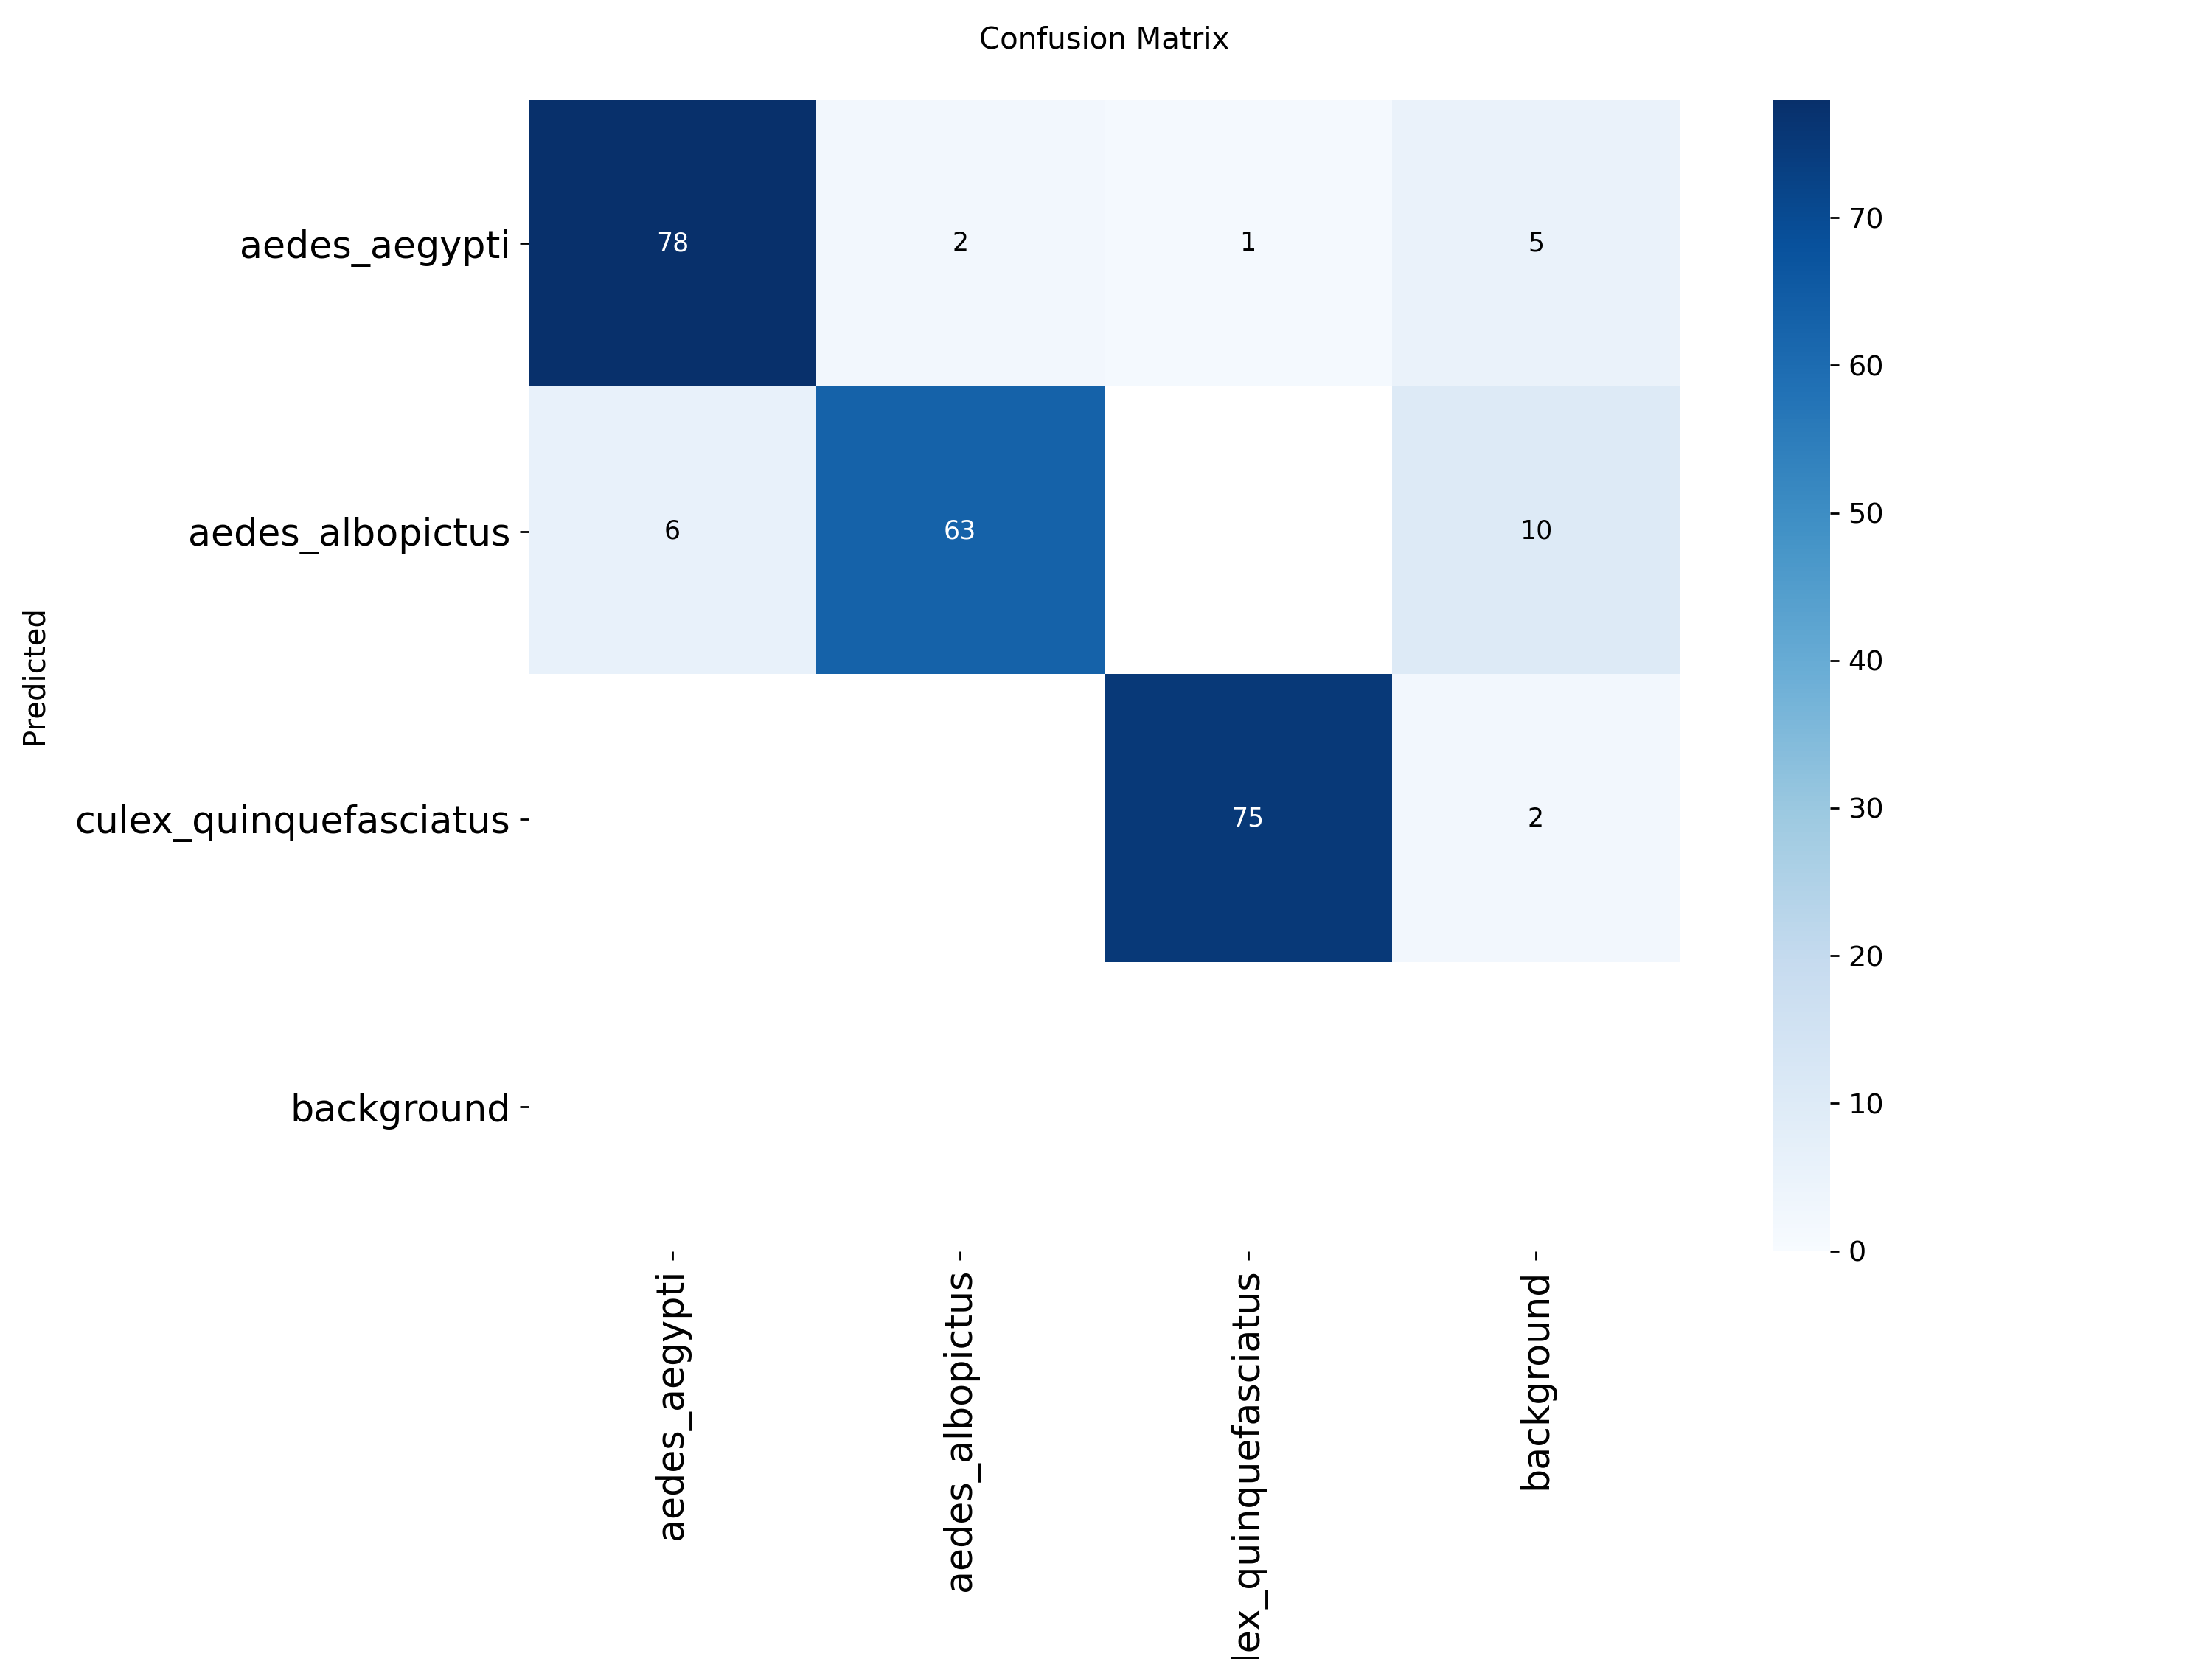

**Confusion Matrix (Normalized)**

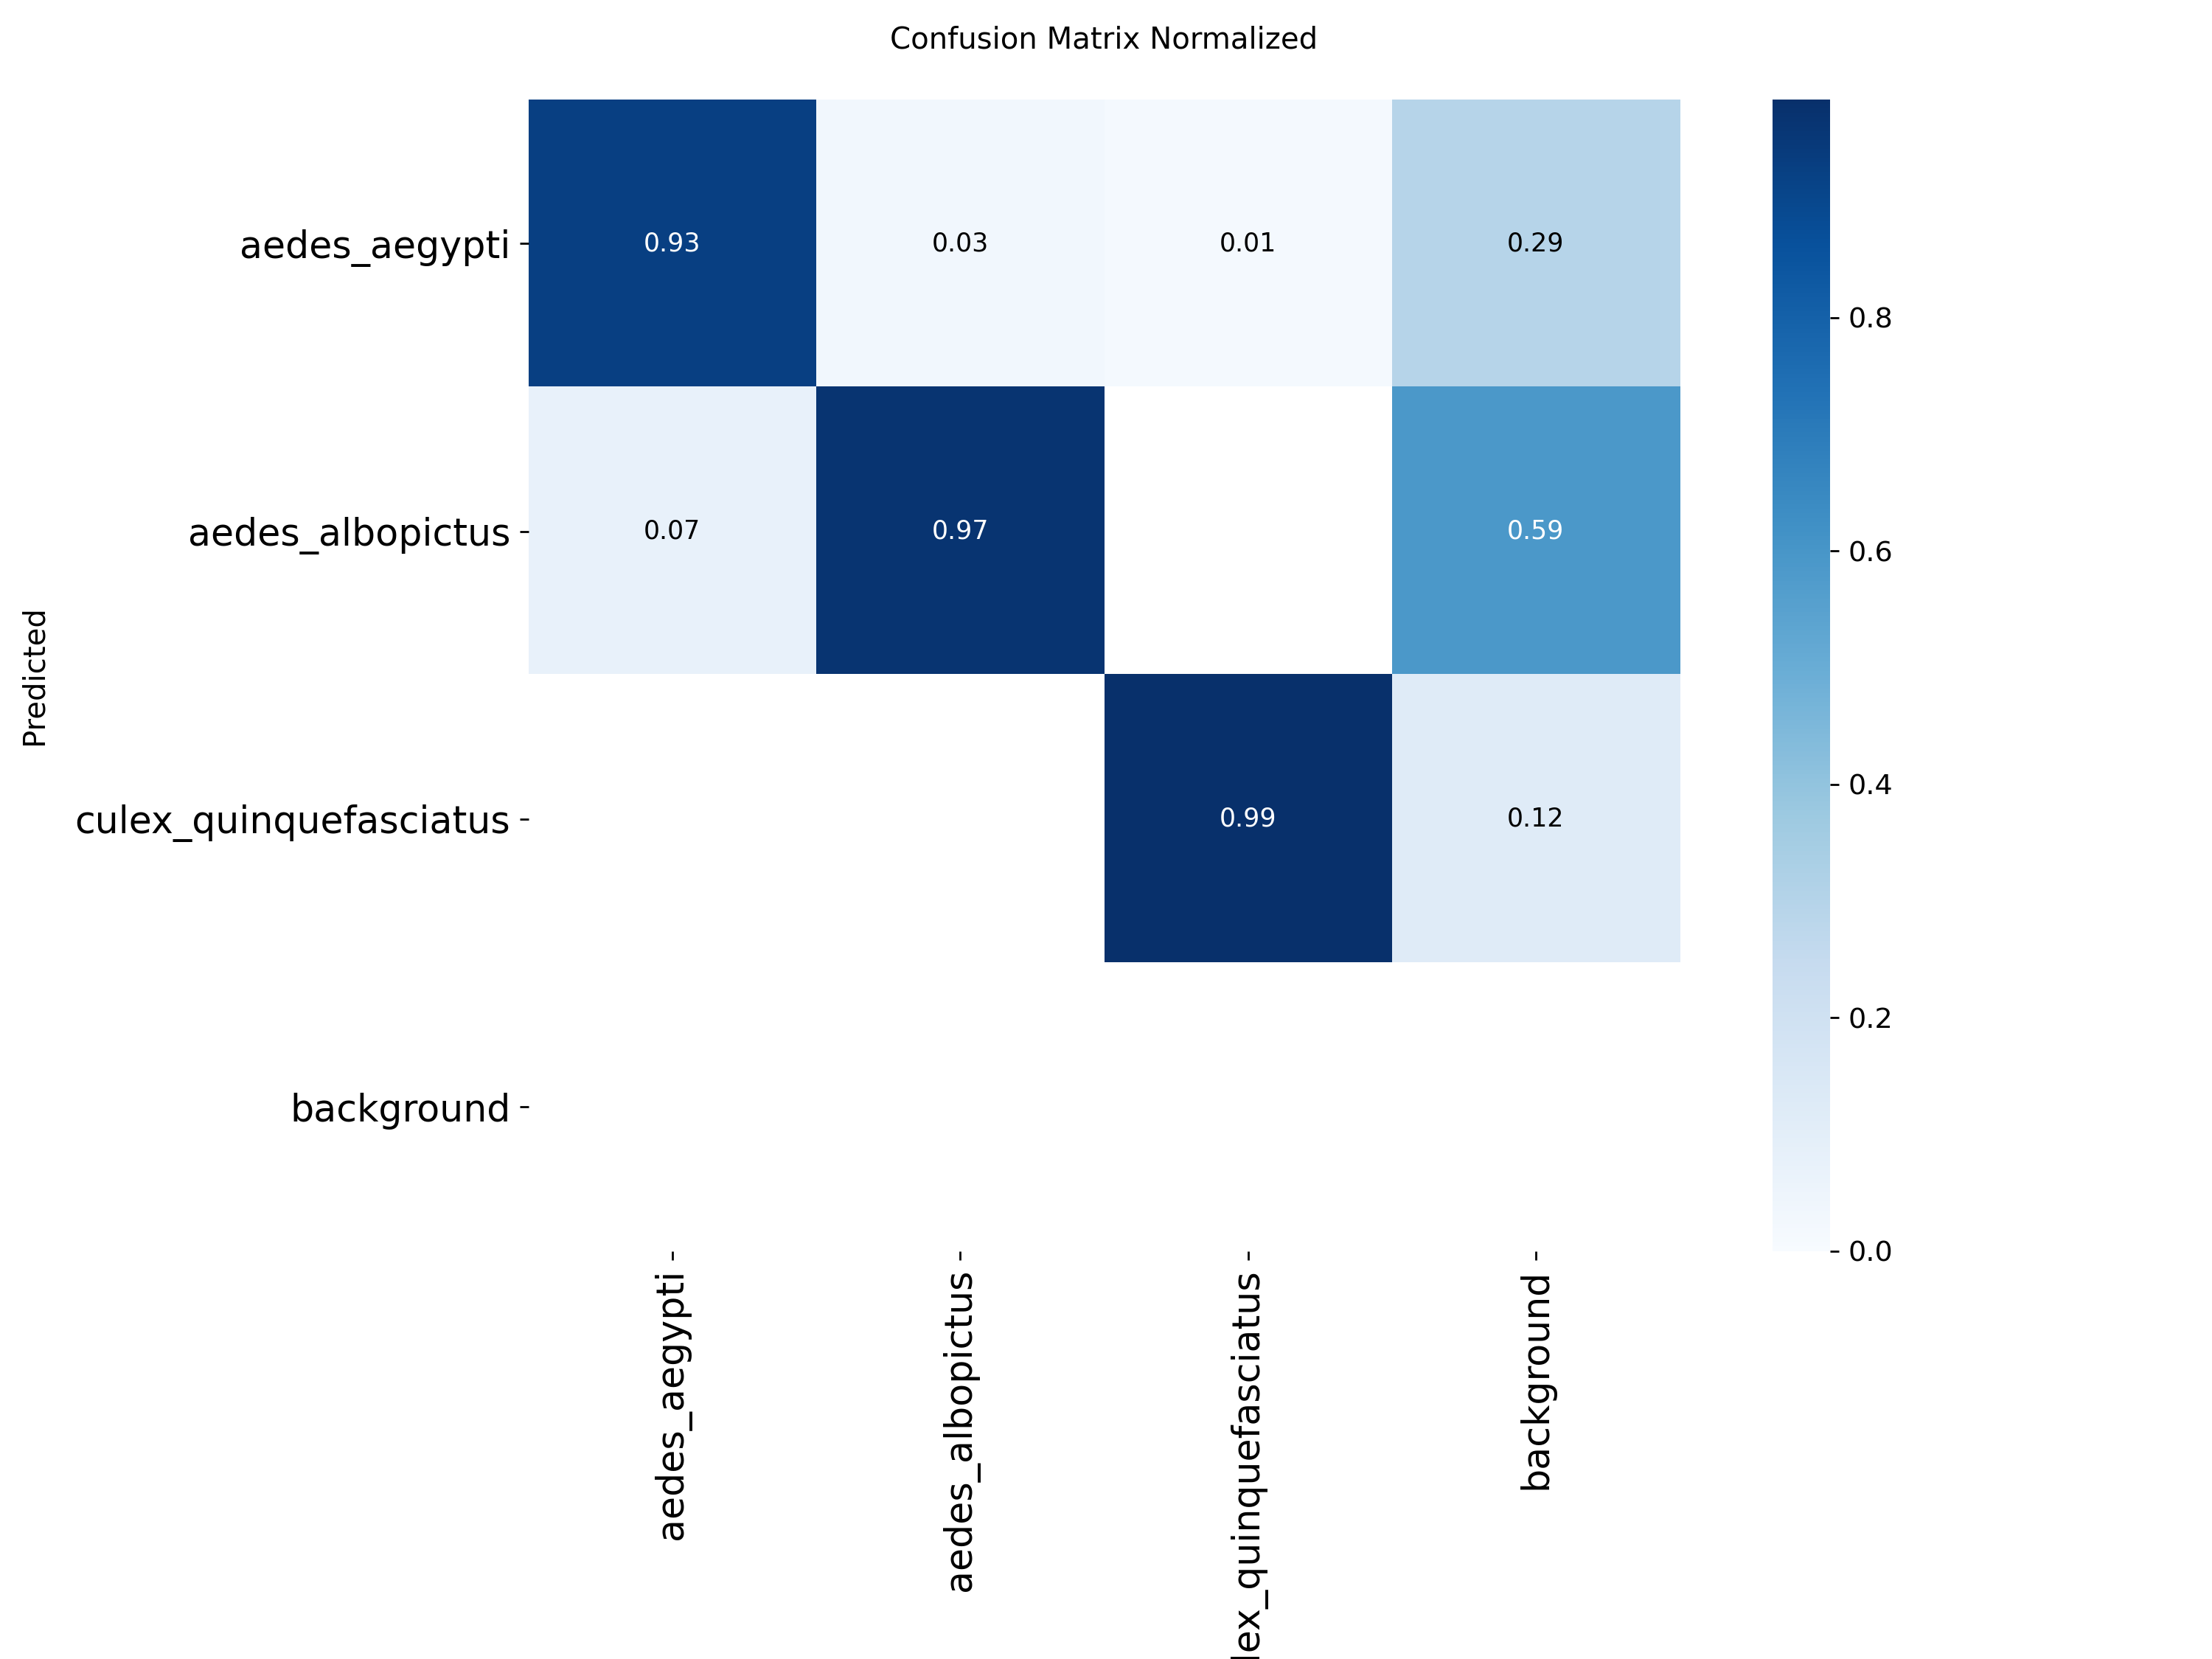

In [68]:

cm_png = save_dir / "confusion_matrix.png"
cm_norm = save_dir / "confusion_matrix_normalized.png"

shown_any = False
if cm_png.exists():
    display(Markdown("**Confusion Matrix**"))
    display(Image(filename=str(cm_png)))
    shown_any = True

if cm_norm.exists():
    display(Markdown("**Confusion Matrix (Normalized)**"))
    display(Image(filename=str(cm_norm)))
    shown_any = True

if not shown_any:
    display(Markdown("*(Belum ada gambar confusion matrix. Pastikan `plots=True` dan jalankan ulang validasi.)*"))



## Kelas
Pemetaan index → nama kelas (jika tersedia).


In [69]:

if isinstance(names, dict) and len(names) > 0:
    display(Markdown("**Classes:**"))
    for i in range(len(names)):
        display(Markdown(f"- {i}: `{names[i]}`"))
elif isinstance(names, list) and len(names) > 0:
    display(Markdown("**Classes:**"))
    for i, n in enumerate(names):
        display(Markdown(f"- {i}: `{n}`"))
else:
    display(Markdown("*(Nama kelas tidak tersedia dari model/hasil.)*"))


**Classes:**

- 0: `aedes_aegypti`

- 1: `aedes_albopictus`

- 2: `culex_quinquefasciatus`


## Tips
- `CONF` rendah (mis. 0.001) untuk evaluasi bisa membantu kurva Precision-Recall lebih stabil.
- `IOU` menentukan matching TP. **Accuracy dari CM** akan bergantung pada nilai IOU ini.
- Untuk evaluasi COCO-style (`save_json=True`) dan per kelas (AP per class), bisa ditambahkan sesuai kebutuhan.
